## Credit Card Fraud Detection

Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import itertools
from itertools import groupby
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers
from keras import backend as K
import keras
        
from HelperMethods import HelperClass

%matplotlib inline

C:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
# Useful methods for plotting results
class HelperClass(object):
        
    # helper method
    @staticmethod
    def stars():
        print ("***********************")
    
    # print metrics as dataframe
    @staticmethod
    def print_dataframe(values):
    
        metrics_print = ['True Positive', 'True Negative', 'False Negative', 'False Positive',
    'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score', 'Roc Auc Score']

        df_metrics = pd.DataFrame(
            {'Metrics': metrics_print,
             'Values': values
            })

        print (df_metrics.to_string(header=False, index=False))
        HelperClass.stars()
        
                
        
    # Disclaimer: metodo obtido em:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    # Metodo para plotar a matrix de confusao
    @staticmethod
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix:")
        else:
            print('Confusion matrix, without normalization:')

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        plt.show()




    # ROC curve
    @staticmethod
    def plot_roc_curve(y_true, y_scores):

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        HelperClass.stars()
        print ("Roc Curve:")
        HelperClass.stars()

        plt.plot(fpr, tpr, label = 'ROC Curve', linewidth = 2)
        plt.plot([0,1],[0,1], 'k--', linewidth = 2)
        plt.title('ROC Curve')
        plt.xlim([0.0, 0.001])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()



    # Precision Recall Curve
    @staticmethod
    def plot_precision_recall_curve(y_true, y_scores):

        HelperClass.stars()
        print ("Precision Recall Curve:")
        HelperClass.stars()

        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

        plt.step(recall, precision, color = 'b', alpha = 0.2, where = 'post')

        plt.plot(recall, precision, linewidth=2)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.show()



    # Show classification report
    @staticmethod
    def show_full_classification_report(y_true, y_pred, y_scores, classes):

        HelperClass.stars()
        print ("Metrics Report:")
        HelperClass.stars()

        cm = confusion_matrix(y_true, y_pred)

        true_positive = cm[1,1]
        true_negative = cm[0,0]
        false_negative = cm[1,0]
        false_positive = cm[0,1]

        accuracy = ((true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive))
        precision = (true_positive/(true_positive + false_positive))
        recall = (true_positive/(true_positive + false_negative))  
        sensitivity = (true_positive/(true_positive + false_negative))  
        specificity = (true_negative/(true_negative + false_positive))  
        f1_score = ((2 * precision * recall)/(precision + recall))
        
        roc_auc = roc_auc_score(y_true, y_scores)

        print ("Classification Report:")
        HelperClass.stars()

        values = []

        values.append(true_positive)
        values.append(true_negative)
        values.append(false_negative)
        values.append(false_positive)
        values.append('{:.4f}'.format(accuracy))
        values.append('{:.4f}'.format(precision))
        values.append('{:.4f}'.format(recall))
        values.append('{:.4f}'.format(specificity))
        values.append('{:.4f}'.format(f1_score))
        values.append('{:.4f}'.format(roc_auc))

        HelperClass.print_dataframe(values)

        HelperClass.plot_confusion_matrix(cm, classes)

        HelperClass.plot_roc_curve(y_true, y_scores)

        HelperClass.plot_precision_recall_curve(y_true, y_scores)

In [3]:
# Load data
df_input = pd.read_csv('creditcard.csv')

In [4]:
# Classes
classes=['Legit', 'Fraud']

In [5]:
df_input.shape

(284807, 31)

In [6]:
df_input.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df_input.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [8]:
df_input.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
df_input.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
# no missing value
df_input.isnull().values.any()

False

In [11]:
df_input[df_input.isnull().T.any().T]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


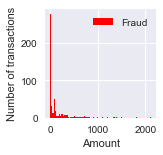

In [12]:
# Histogram with Amount of fraud transactions vs Amount legit of transactions
# Obs: fraud in red (very small amount)

figure = plt.figure(figsize=(2, 2))
plt.hist([df_input[df_input['Class'] == 1]['Amount']], color = ['r'],
         bins = 80, label = ['Fraud'])

plt.xlabel('Amount')
plt.ylabel('Number of transactions')
plt.legend()
plt.show()

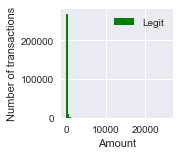

In [13]:
# Histogram with Amount of fraud transactions vs Amount legit of transactions
# Obs: fraud in red (very small amount)

figure = plt.figure(figsize=(2, 2))
plt.hist([df_input[df_input['Class'] == 0]['Amount']], color = ['g'],
         bins = 80, label = ['Legit'])

plt.xlabel('Amount')
plt.ylabel('Number of transactions')
plt.legend()
plt.show()

In [14]:
def GetTime(seconds):
    sec = timedelta(seconds=seconds)
    d = (datetime(1,1,1) + sec)
    return int(str(d).split(" ")[1].split(":")[0])

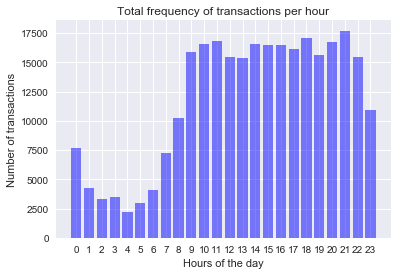

In [15]:
timer_total = df_input['Time'].values.tolist()

hours = []

for time in timer_total:
    hours.append(GetTime(time))

hours.sort()

frequencies = [len(list(group)) for key, group in groupby(hours)]

hour_columns = list(range(0, 24))

y_pos = np.arange(len(hour_columns))

plt.bar(y_pos, frequencies, align='center', alpha=0.5, color='blue')

plt.xticks(y_pos, hour_columns)

plt.xlabel('Hours of the day')

plt.ylabel('Number of transactions')

plt.title('Total frequency of transactions per hour')

plt.show()

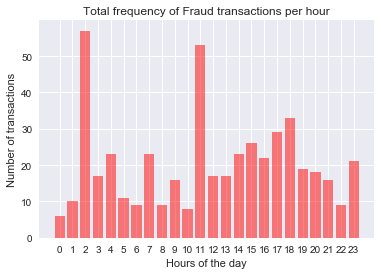

In [16]:
timer_fraud = df_input.Time[df_input.Class == 1]

hours = []

for time in timer_fraud:
    hours.append(GetTime(time))

hours.sort()

frequencies = [len(list(group)) for key, group in groupby(hours)]

hour_columns = list(range(0, 24))

y_pos = np.arange(len(hour_columns))

plt.bar(y_pos, frequencies, align='center', alpha=0.5, color='red')

plt.xticks(y_pos, hour_columns)

plt.xlabel('Hours of the day')

plt.ylabel('Number of transactions')

plt.title('Total frequency of Fraud transactions per hour')

plt.show()

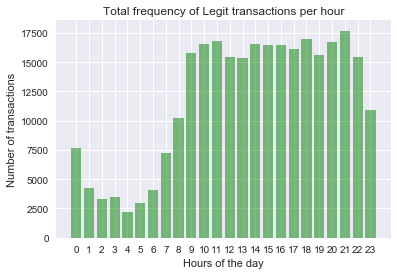

In [17]:
timer_legit = df_input.Time[df_input.Class == 0]

hours = []

for time in timer_legit:
    hours.append(GetTime(time))

hours.sort()

frequencies = [len(list(group)) for key, group in groupby(hours)]

hour_columns = list(range(0, 24))

y_pos = np.arange(len(hour_columns))

plt.bar(y_pos, frequencies, align='center', alpha=0.5, color='green')

plt.xticks(y_pos, hour_columns)

plt.xlabel('Hours of the day')

plt.ylabel('Number of transactions')

plt.title('Total frequency of Legit transactions per hour')

plt.show()

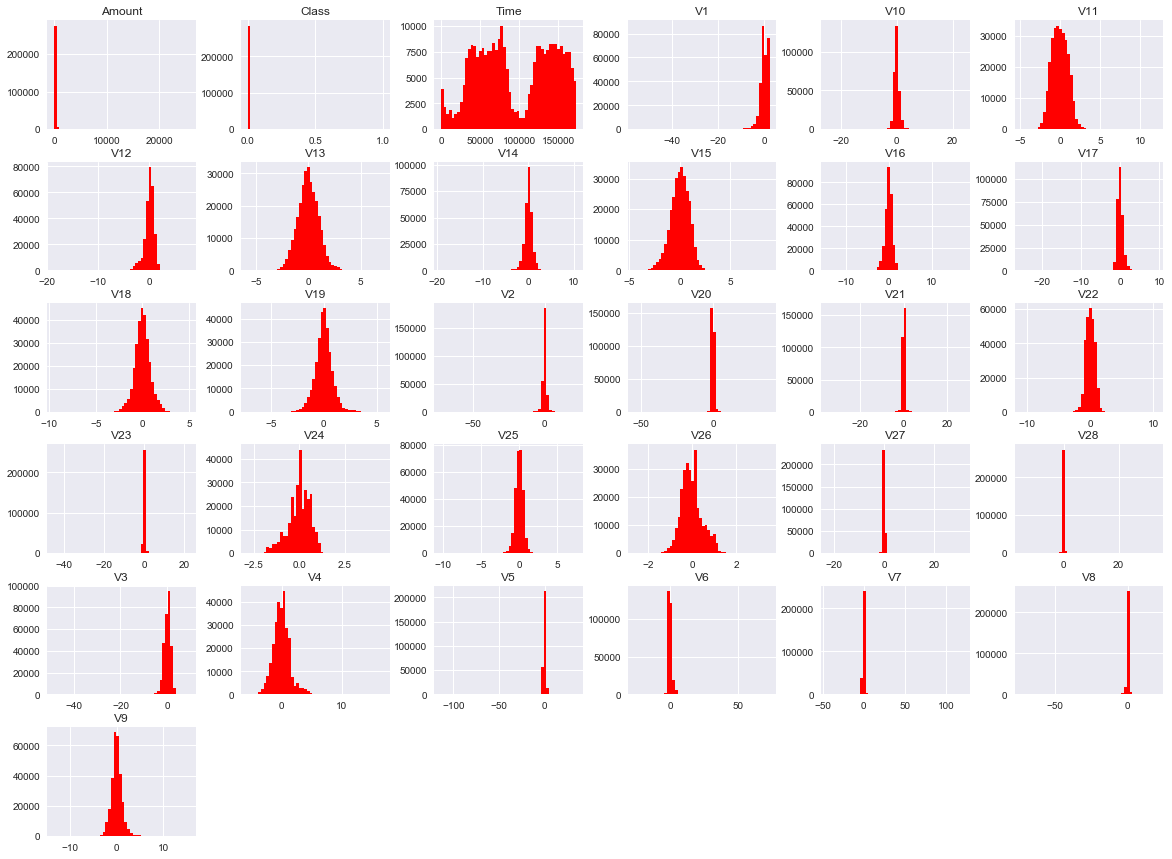

In [18]:
# Distribution of fraud transactions per each feature (exluding time)
df_input.hist(bins=50, figsize=(20,15), color = 'red')
plt.show()

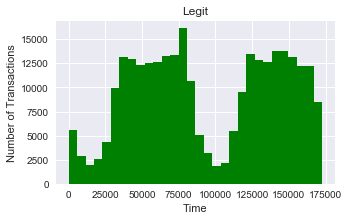

In [19]:
# Histogram of legit transactions over time

figure = plt.figure(figsize=(5, 3))

plt.hist(df_input.Time[df_input.Class == 0], bins = 30, color = 'green')
plt.title('Legit')

plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

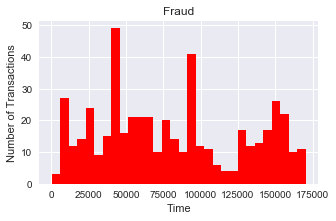

In [20]:
# Histogram of fraud transactions over time

figure = plt.figure(figsize=(5, 3))

plt.hist(df_input.Time[df_input.Class == 1], bins = 30, color = 'red')
plt.title('Fraud')

plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

In [21]:
X = df_input.drop(['Class'], axis = 1).values
y = df_input.loc[:, ['Class']].values

legit = np.count_nonzero(y == 0)
fraud = np.count_nonzero(y == 1)
total = (legit + fraud)

print ('Total transactions: {0} '.format(total))
print ('Legit transactions: {0} | {1}%'.format(legit, "{0:.2f}".format(legit*100/total),2))
print ('Fraud transactions: {0} | {1}%'.format(fraud, "{0:.2f}".format(fraud*100/total),2))

Total transactions: 284807 
Legit transactions: 284315 | 99.83%
Fraud transactions: 492 | 0.17%


In [22]:
# Normalization of amount and time
# Obs: The other features were created using PCA, so no need for scaling
df_input['Amount'] = StandardScaler().fit_transform(df_input['Amount'].values.reshape(-1,1))
df_input['Time'] = StandardScaler().fit_transform(df_input['Time'].values.reshape(-1,1))

In [23]:
#feature importance plot
def plot_feature_importance(features, columns):
    tmp = pd.DataFrame({'Feature': columns, 'Feature importance': features})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (15,8))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

In [24]:
useful_columns = df_input.drop(['Class'], axis = 1).columns
useful_columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

C:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


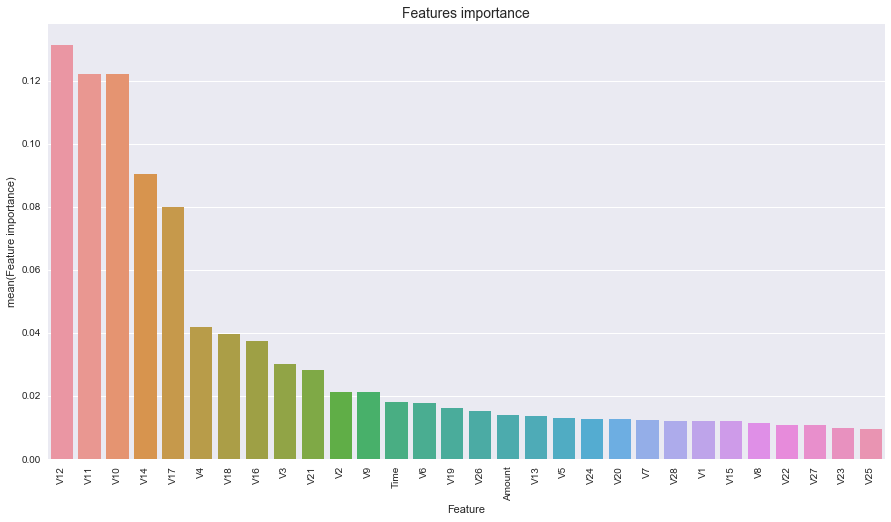

In [25]:
# Feature importances using a Tree based model

clf_Tree = ExtraTreesClassifier()
clf_Tree.fit(X, y)
features_Tree = clf_Tree.feature_importances_

plot_feature_importance(features_Tree, useful_columns)

#10 Features mais importantes: V12, V14, V17, V11, V16, V4, V19, V7, V1, V5

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


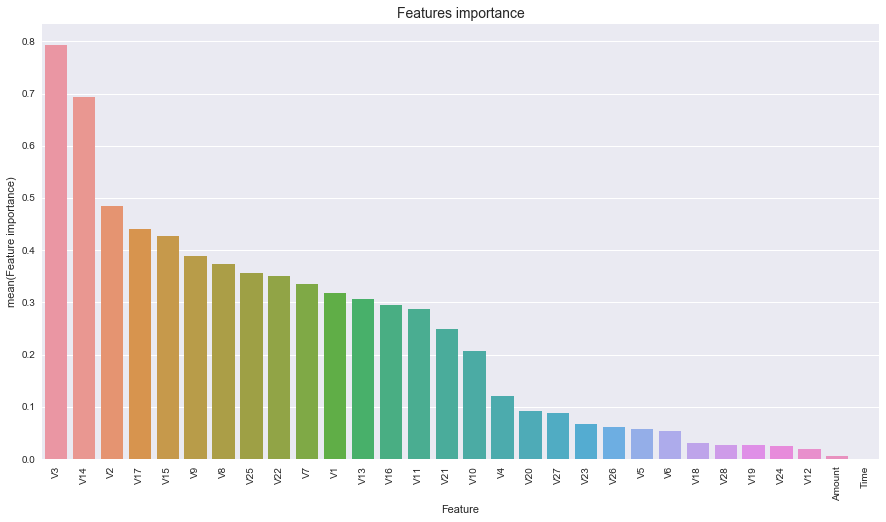

In [26]:
# Feature importances using Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X, y)
features_LR = abs(clf_LR.coef_[0])

plot_feature_importance(features_LR, useful_columns)

#10 Features mais importantes: V3, V14, V17, V9, V13, V15, V22, V1, V25, V16

In [27]:
# X and y
X = np.array(df_input.loc[:, ['V12', 'V14', 'V17', 'V11', 'V16', 'V4', 'V19', 'V7', 'V1', 'V5']].as_matrix())
y = np.array(df_input.loc[:, 'Class'].values.tolist())

In [28]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [29]:
# Logistic Regression
# Grid Search for best recall

clf_LR = LogisticRegression()


param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.001, 0.01, 0.1, 1, 10]
            }

clf_LR_grid_search = GridSearchCV(estimator = clf_LR, param_grid = param_grid , scoring = 'recall', n_jobs = -1)
clf_LR_grid_search.fit(X_train, y_train)

print ('Best Params:', clf_LR_grid_search.best_params_)
print ('Best Recall:', clf_LR_grid_search.best_score_)

Best Params: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}
Best Recall: 0.8938836495292156


***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive     105
 True Negative   55334
False Negative      10
False Positive    1513
      Accuracy  0.9733
     Precision  0.0649
        Recall  0.9130
   Specificity  0.9734
      F1 Score  0.1212
 Roc Auc Score  0.9780
***********************
Confusion matrix, without normalization:


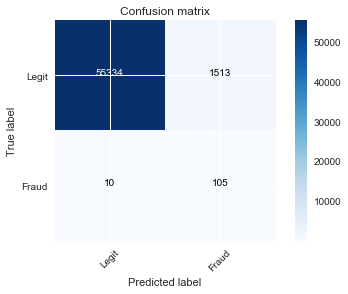

***********************
Roc Curve:
***********************


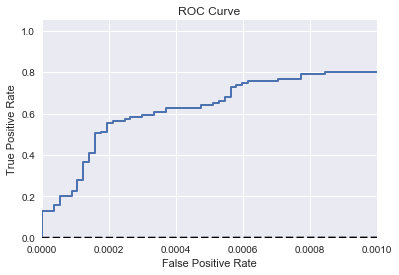

***********************
Precision Recall Curve:
***********************


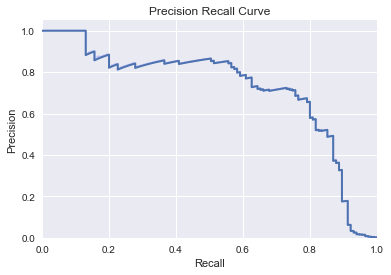

In [30]:
# Fit and Predict
y_pred = clf_LR_grid_search.predict(X_test)
y_scores_LR = clf_LR_grid_search.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_LR, classes)

In [31]:
clf_kNN = KNeighborsClassifier()

param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
            }

clf_kNN_grid_search = GridSearchCV(estimator = clf_kNN, param_grid = param_grid , scoring = 'recall', n_jobs = -1)
clf_kNN_grid_search.fit(X_train, y_train)

print ('Best Params:', clf_kNN_grid_search.best_params_)
print ('Best Recall:', clf_kNN_grid_search.best_score_)

Best Params: {'n_neighbors': 3, 'weights': 'uniform'}
Best Recall: 0.7850584912396933


***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive      94
 True Negative   56838
False Negative      21
False Positive       9
      Accuracy  0.9995
     Precision  0.9126
        Recall  0.8174
   Specificity  0.9998
      F1 Score  0.8624
 Roc Auc Score  0.9216
***********************
Confusion matrix, without normalization:


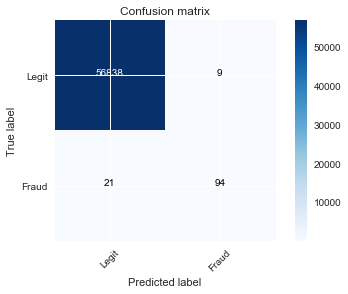

***********************
Roc Curve:
***********************


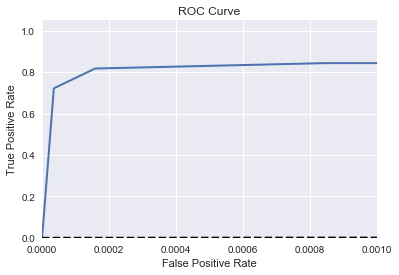

***********************
Precision Recall Curve:
***********************


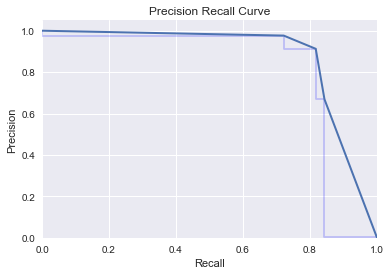

In [32]:
# Fit and Predict
y_pred = clf_kNN_grid_search.predict(X_test)
y_scores_kNN = clf_kNN_grid_search.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_kNN, classes)

In [33]:
# Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)

GaussianNB(priors=None)

***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive     100
 True Negative   56294
False Negative      15
False Positive     553
      Accuracy  0.9900
     Precision  0.1531
        Recall  0.8696
   Specificity  0.9903
      F1 Score  0.2604
 Roc Auc Score  0.9719
***********************
Confusion matrix, without normalization:


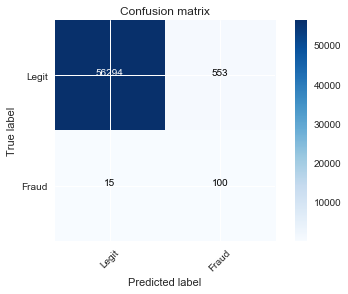

***********************
Roc Curve:
***********************


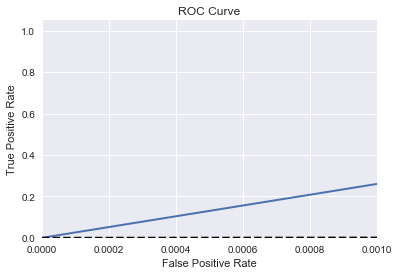

***********************
Precision Recall Curve:
***********************


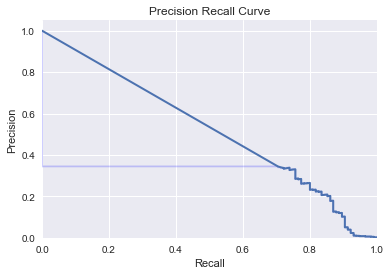

In [34]:
# Fit and Predict
y_pred = clf_NB.predict(X_test)
y_scores_NB = clf_NB.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_NB, classes)

In [35]:
clf_RF = RandomForestClassifier()

param_grid = {
            'n_estimators': [100],
            'max_features': [2],
            'min_samples_leaf': [2],
            'min_samples_split': [2]
            }

clf_RF_grid_search = GridSearchCV(estimator = clf_RF, param_grid = param_grid , scoring = 'recall', n_jobs = -1)
clf_RF_grid_search.fit(X_train, y_train)

print ('Best Params:', clf_RF_grid_search.best_params_)
print ('Best Recall:', clf_RF_grid_search.best_score_)

Best Params: {'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Recall: 0.7558100488113787


***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive      90
 True Negative   56835
False Negative      25
False Positive      12
      Accuracy  0.9994
     Precision  0.8824
        Recall  0.7826
   Specificity  0.9998
      F1 Score  0.8295
 Roc Auc Score  0.9678
***********************
Confusion matrix, without normalization:


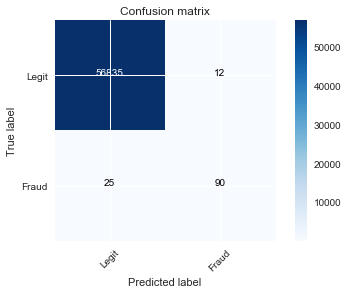

***********************
Roc Curve:
***********************


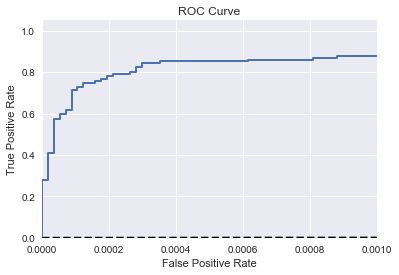

***********************
Precision Recall Curve:
***********************


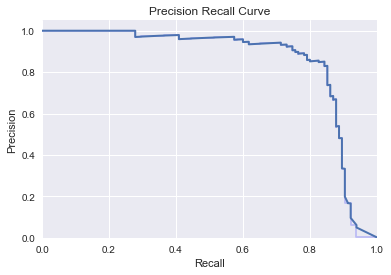

In [36]:
# Fit and Predict
y_pred = clf_RF_grid_search.predict(X_test)
y_scores_RF = clf_RF_grid_search.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_RF, classes)

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive      98
 True Negative   56827
False Negative      17
False Positive      20
      Accuracy  0.9994
     Precision  0.8305
        Recall  0.8522
   Specificity  0.9996
      F1 Score  0.8412
 Roc Auc Score  0.9785
***********************
Confusion matrix, without normalization:


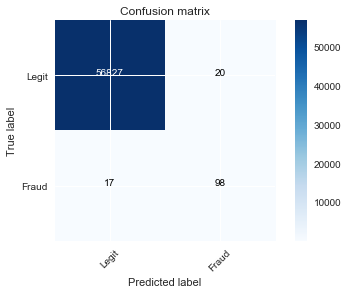

***********************
Roc Curve:
***********************


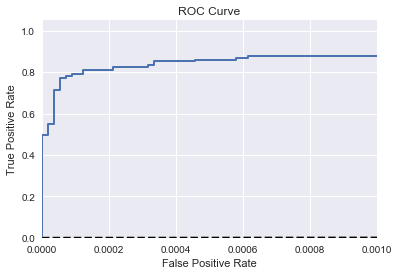

***********************
Precision Recall Curve:
***********************


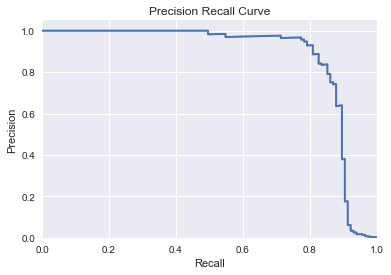

In [37]:
# Soft Voting Classifier (Combines all 3 classifiers into one)
voting_clf = VotingClassifier (
        estimators = [('lg', clf_LR_grid_search), ('knn', clf_kNN), ('rf', clf_RF_grid_search)], voting='soft')
    
voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
y_scores_VotingClassifier = voting_clf.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_VotingClassifier, classes)

***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive      96
 True Negative   56830
False Negative      19
False Positive      17
      Accuracy  0.9994
     Precision  0.8496
        Recall  0.8348
   Specificity  0.9997
      F1 Score  0.8421
 Roc Auc Score  0.9788
***********************
Confusion matrix, without normalization:


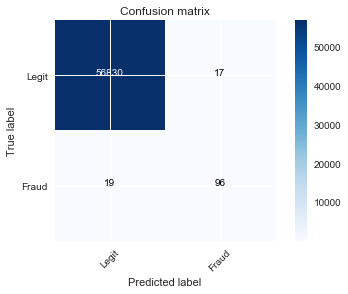

***********************
Roc Curve:
***********************


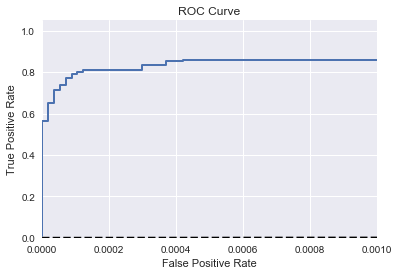

***********************
Precision Recall Curve:
***********************


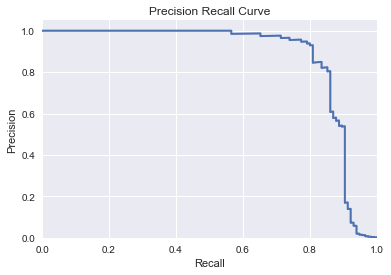

In [38]:
# Stacking Classifier (Ensemble model)
stacking_clf = StackingClassifier(classifiers=[clf_LR_grid_search, clf_kNN_grid_search, clf_RF_grid_search],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=LogisticRegression())


stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)
y_scores_StackingClassifier = stacking_clf.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_StackingClassifier, classes)

In [39]:
# lightgbm object
lgb_train_data = lgb.Dataset(X_train, label=y_train)

# Parameters
params = {'learning_rate': 0.05,
          'num_class' : 1,
          'metric' : 'binary_error',
          'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 50,
          'max_bin': 400,
          'subsample_for_bin': 100,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          }

In [40]:
# Create parameters to search
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05],
    'n_estimators': [10,20,30,40],
    'num_leaves': [16, 20, 24, 28, 32, 36],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [123], 
    }

In [41]:
# LightGBM Classifier
clf_lgbm = lgb.LGBMClassifier(boosting_type= 'gbdt',
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          objective = 'binary',
          n_jobs = -1,)

In [42]:
clf_lgbm.get_params().keys()

# Grid search
clf_grid_search = GridSearchCV(clf_lgbm, param_grid = param_grid, verbose=2, cv=5, scoring = 'f1', n_jobs = -1)

clf_grid_search.fit(X_train, y_train)

# Print the best parameters found
print(clf_grid_search.best_params_)
print(clf_grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.7min finished


{'boosting_type': 'gbdt', 'learning_rate': 0.03, 'n_estimators': 30, 'num_leaves': 28, 'objective': 'binary', 'random_state': 123}
0.7474181226324056


In [43]:
# Apply best parameters from grid search
params['learning_rate'] = clf_grid_search.best_params_['learning_rate']
params['num_leaves'] = clf_grid_search.best_params_['num_leaves']
params['n_estimators'] = clf_grid_search.best_params_['n_estimators']
params['random_state'] = clf_grid_search.best_params_['random_state']

C:\anaconda\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive      76
 True Negative   56832
False Negative      39
False Positive      15
      Accuracy  0.9991
     Precision  0.8352
        Recall  0.6609
   Specificity  0.9997
      F1 Score  0.7379
 Roc Auc Score  0.9695
***********************
Confusion matrix, without normalization:


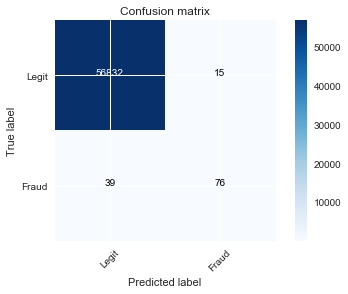

***********************
Roc Curve:
***********************


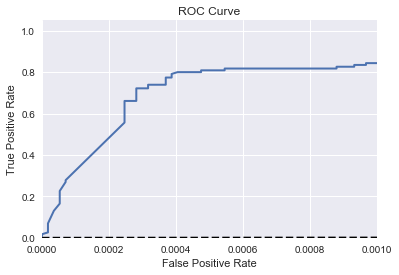

***********************
Precision Recall Curve:
***********************


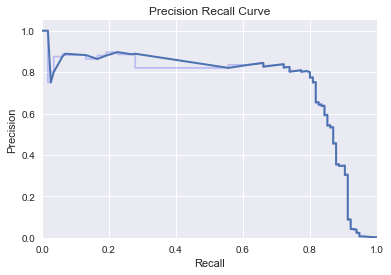

In [44]:
# Training
clf_lgbm = lgb.train(params, lgb_train_data, 200)

# Prediction with probabilities
y_scores_LightGBM = clf_lgbm.predict(X_test)

# Predictions binary
threshold = 0.5
y_pred = np.where(y_scores_LightGBM > threshold, 1, 0)

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_LightGBM, classes)

In [45]:
# Keras Artificial Neural Network (ANN) model
model = Sequential()
model.add(Dense(8, activation='relu',
                kernel_initializer = keras.initializers.glorot_uniform(seed=None),
                input_dim=(X.shape[1])))


model.add(Dense(16, activation='relu',
               kernel_initializer = keras.initializers.glorot_uniform(seed=None)))

model.add(Dense(32, activation='relu',
               kernel_initializer = keras.initializers.glorot_uniform(seed=None)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid',
               kernel_initializer = keras.initializers.glorot_uniform(seed=None)))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# Model compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[recall])

In [47]:
# Model fit
model.fit(X_train, y_train,
          epochs=3,
          batch_size=128,
          validation_split = 0.3)

Train on 159491 samples, validate on 68354 samples
Epoch 1/3
159491/159491 [==============================] - 872s 5ms/step - loss: 0.0408 - recall: 0.0329 - val_loss: 0.0044 - val_recall: 0.1236
Epoch 2/3
159491/159491 [==============================] - 862s 5ms/step - loss: 0.0047 - recall: 0.1304 - val_loss: 0.0038 - val_recall: 0.1330
Epoch 3/3
159491/159491 [==============================] - 901s 6ms/step - loss: 0.0045 - recall: 0.1481 - val_loss: 0.0037 - val_recall: 0.1339


***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive      90
 True Negative   56834
False Negative      25
False Positive      13
      Accuracy  0.9993
     Precision  0.8738
        Recall  0.7826
   Specificity  0.9998
      F1 Score  0.8257
 Roc Auc Score  0.9671
***********************
Confusion matrix, without normalization:


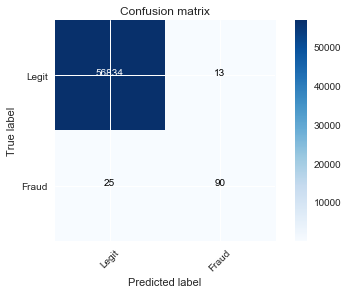

***********************
Roc Curve:
***********************


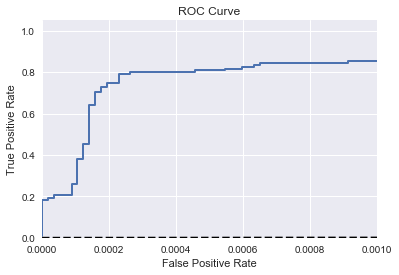

***********************
Precision Recall Curve:
***********************


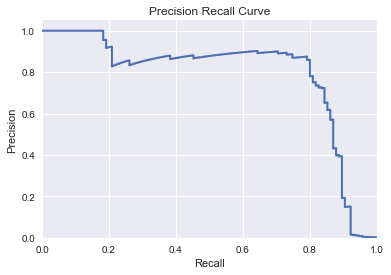

In [50]:
# Predict
y_scores_ANN = model.predict(X_test)
y_pred = [1 if element > 0.5 else 0 for element in y_scores_ANN]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_ANN, classes)

***********************
All Roc Curves:
***********************


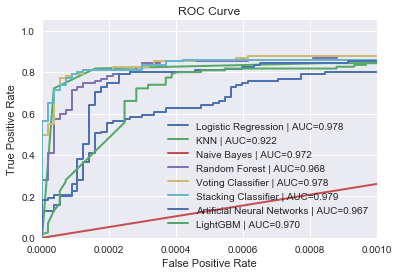

In [52]:
# Roc curve for all models
HelperClass.stars()
print ("All Roc Curves:")
HelperClass.stars()


plt.figure()

# Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, y_scores_LR)
auc = '{:.3f}'.format(roc_auc_score(y_test, y_scores_LR))
plt.plot(fpr, tpr, label = 'Logistic Regression | AUC='+str(auc), linewidth = 2)


# k Nearest Neighbors
fpr, tpr, thresholds = roc_curve(y_test, y_scores_kNN)
auc = '{:.3f}'.format(roc_auc_score(y_test, y_scores_kNN))
plt.plot(fpr, tpr, label = 'KNN | AUC='+str(auc), linewidth = 2)

# Naive Bayes
fpr, tpr, thresholds = roc_curve(y_test, y_scores_NB)
auc = '{:.3f}'.format(roc_auc_score(y_test, y_scores_NB))
plt.plot(fpr, tpr, label = 'Naive Bayes | AUC='+str(auc), linewidth = 2)


# Random Forest
fpr, tpr, thresholds = roc_curve(y_test, y_scores_RF)
auc = '{:.3f}'.format(roc_auc_score(y_test, y_scores_RF))
plt.plot(fpr, tpr, label = 'Random Forest | AUC='+str(auc), linewidth = 2)


# Voting Classifier
fpr, tpr, thresholds = roc_curve(y_test, y_scores_VotingClassifier)
auc = '{:.3f}'.format(roc_auc_score(y_test, y_scores_VotingClassifier))
plt.plot(fpr, tpr, label = 'Voting Classifier | AUC='+str(auc), linewidth = 2)


# Stacking Classifier
fpr, tpr, thresholds = roc_curve(y_test, y_scores_StackingClassifier)
auc = '{:.3f}'.format(roc_auc_score(y_test, y_scores_StackingClassifier))
plt.plot(fpr, tpr, label = 'Stacking Classifier | AUC='+str(auc), linewidth = 2)


# Artificial Neural Network (ANN)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_ANN)
auc = '{:.3f}'.format(roc_auc_score(y_test, y_scores_ANN))
plt.plot(fpr, tpr, label = 'Artificial Neural Networks | AUC='+str(auc), linewidth = 2)


# LightGBM
fpr, tpr, thresholds = roc_curve(y_test, y_scores_LightGBM)
auc = '{:.3f}'.format(roc_auc_score(y_test, y_scores_LightGBM))
plt.plot(fpr, tpr, label = 'LightGBM | AUC='+str(auc), linewidth = 2)


# Plot
plt.title('ROC Curve')
plt.xlim([0.0, 0.001])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)
plt.show()

## Conclusion

The best models were the Voting Classifier and the Stacking Classifier, both from the family of Multiclassifier models. The Random Forest and the Artificial Neural Network model could have performed better with a better CPU to search for better parameters. The Naive Bayes, as expected, performed very poorly.